### hypotheses
1. rain&wind reduces, while humidity increases PM2.5
2. less PM2.5 in polar zones & tropical-zones, more in temperate & continental Zones
    - polar: no humans, stagnant weather patterns trap PM2.5
    - tropical-zones (rain washes it out)
    - temperate/contintental - more humans & weather patterns conducive to trapping PM2.5
3. PM2.5 increase in urban areas
    - urban = high NO2
    - weekends = less PM2.5, because people relax
4. Higher Concentration of gases (CO,NO2,AER_AI?,) correlate positively with PM2.5 


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

RSEED=826

In [121]:
# import data and immediate train test split
df = pd.read_csv('data/data.csv')

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df_train, df_test = train_test_split(df, random_state=RSEED)


In [122]:
df_train.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

In [123]:
df_train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
3121,2JZW8ZM X 2020-03-09,2020-03-09,2JZW8ZM,27.0,1.0,115.0,1611.93,253,13.070044,86.133336,...,40.859311,-7.812209,57.584962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14141,EVXOAKQ X 2020-03-25,2020-03-25,EVXOAKQ,21.0,5.0,157.0,4908.25,56,26.500000,75.900002,...,57.229369,-121.763823,33.091599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18250,J3HFUPO X 2020-03-24,2020-03-24,J3HFUPO,114.0,63.0,161.0,4848.00,333,20.200001,97.099998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1466,1LC5FAK X 2020-01-03,2020-01-03,1LC5FAK,25.0,5.0,55.0,1144.47,47,14.400000,84.150002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13997,EVB4HVG X 2020-02-04,2020-02-04,EVB4HVG,55.0,9.0,682.0,34813.40,445,26.342857,63.071432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# drop columns with sensor angles as they are not useful for prediction
# as well as 'amf' columns as they hold same information as columns with almost identical name just in different format
for col in df_train.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df_train.drop([col], axis=1, inplace=True)
        df_test.drop([col], axis=1, inplace=True)

# drop CH4 columns as they include too many nan values
# drop NO2_tropopause_pressure because its highly irregular and probably a weak predictor
drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth', "L3_NO2_tropopause_pressure"]
df_train.drop(drop_cols, axis=1, inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

U = df_train['u_component_of_wind_10m_above_ground']
V = df_train['v_component_of_wind_10m_above_ground']
wind_drop=['u_component_of_wind_10m_above_ground','v_component_of_wind_10m_above_ground']
# 1) Wind speed (m/s)
df_train['wind_speed'] = np.hypot(U.to_numpy(), V.to_numpy())
print(df_train[['wind_speed']].min(),df_train[['wind_speed']].max())
df_train.drop(wind_drop,axis=1,inplace=True)

U_t = df_test['u_component_of_wind_10m_above_ground']
V_t = df_test['v_component_of_wind_10m_above_ground']
df_test['wind_speed'] = np.hypot(U_t.to_numpy(), V_t.to_numpy())
df_test.drop(wind_drop,axis=1,inplace=True)



df_train.info()

wind_speed    0.02004
dtype: float64 wind_speed    18.160623
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 22917 entries, 3121 to 29745
Data columns (total 43 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Place_ID X Date                                  22917 non-null  object        
 1   Date                                             22917 non-null  datetime64[ns]
 2   Place_ID                                         22917 non-null  object        
 3   target                                           22917 non-null  float64       
 4   target_min                                       22917 non-null  float64       
 5   target_max                                       22917 non-null  float64       
 6   target_variance                                  22917 non-null  float64       
 7   target_count                                   

In [125]:
# drop rows where target value is above 500 as this is already a very extreme value for pm2.5 concentration
df_train = df_train[df_train['target'] < 500]
df_test = df_test[df_test['target'] < 500]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 43 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Place_ID X Date                                  22912 non-null  object        
 1   Date                                             22912 non-null  datetime64[ns]
 2   Place_ID                                         22912 non-null  object        
 3   target                                           22912 non-null  float64       
 4   target_min                                       22912 non-null  float64       
 5   target_max                                       22912 non-null  float64       
 6   target_variance                                  22912 non-null  float64       
 7   target_count                                     22912 non-null  int64         
 8   precipitable_water_entire_atmosphere  

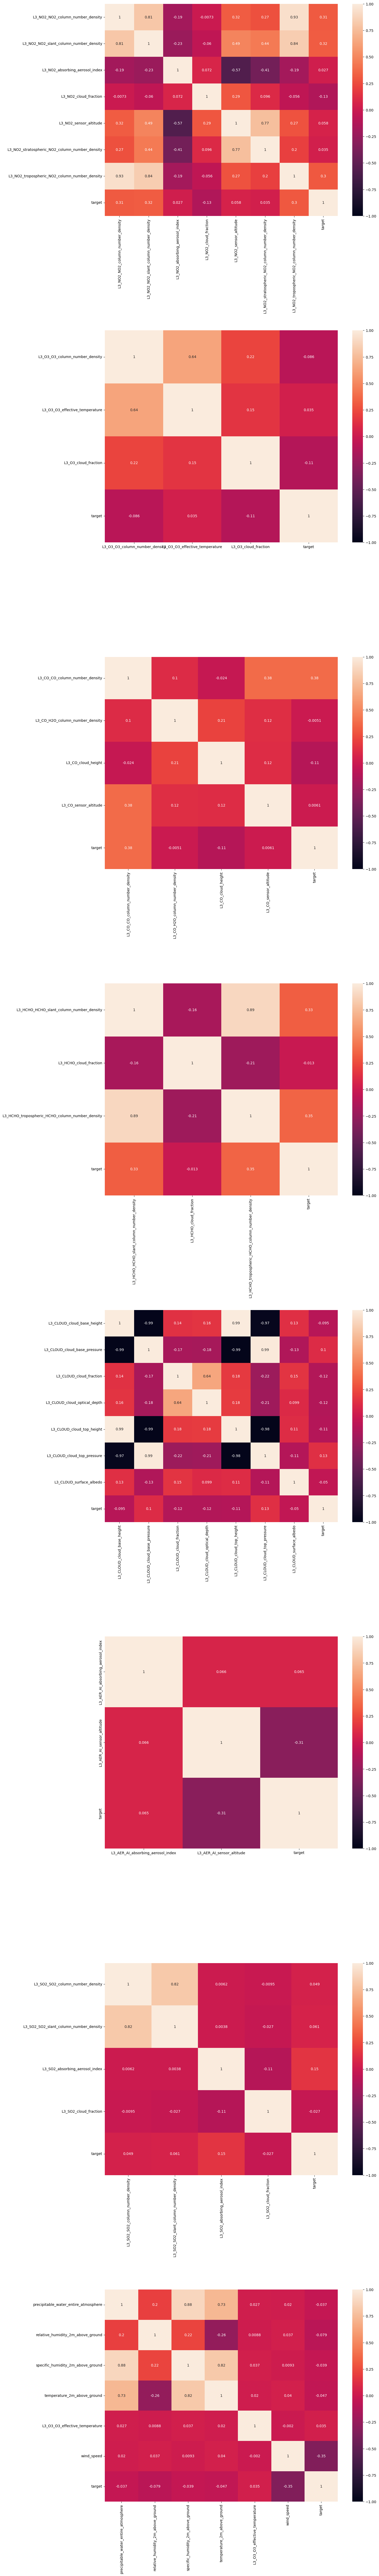

In [126]:
# visualize correlations between columns for each gas separately
gases = ['NO2', 'O3', 'CO', 'HCHO', 'CLOUD', 'AER', 'SO2']

fig, axes = plt.subplots(len(gases)+1, 1, figsize=(16, 100))
axes = axes.flatten()

for ax, gas in zip(axes, gases):
    col_keeps = [col for col in df_train.columns if gas in col]
    corr_gas = df_train[col_keeps + ['target']]
    sns.heatmap(corr_gas.corr(), annot=True, ax=ax, vmin=-1, vmax=1)

# ... and cluster the cols below as weather
weather = ['humidity', 'wind', 'water', 'temperature']

col_keeps = [col for col in df_train.columns for w in weather if w in col]
corr_weather = df_train[col_keeps + ['target']]
sns.heatmap(corr_weather.corr(), annot=True, ax=axes[-1], vmin=-1, vmax=1)

plt.tight_layout(pad = 3)

In [127]:
# drop one of two columns which correlate strongly (>0.7) to prevent multicollinearity
use = ['target'] + list(df_train.columns[8:])
corr_df = df_train[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold) and column != 'temperature_2m_above_ground' and column !='L3_HCHO_tropospheric_HCHO_column_number_density']
print(f'Columns to drop [{len(to_drop)}]: {to_drop}\n')

df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)
df_train.drop(['L3_HCHO_HCHO_slant_column_number_density'],axis=1, inplace=True)
df_test.drop(['L3_HCHO_HCHO_slant_column_number_density',],axis=1,inplace=True)
df_train.info()


Columns to drop [15]: ['specific_humidity_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_cloud_fraction']

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Place_ID X Date                                  22912 non-null  object        
 1   Date                                             22912 non-null  datetime64[ns]
 2   Place_ID     

In [135]:
# check for duplicates
summary = pd.DataFrame({
    'n_unique': df_train.nunique(),
    'n_duplicates': df_train.apply(lambda col: col.duplicated().sum()),
    'dup_percent': df_train.apply(lambda col: col.duplicated().mean() * 100)
}).sort_values('dup_percent', ascending=False)

summary

,n_unique,n_duplicates,dup_percent
Date,94,22818,99.589735
target_min,254,22658,98.891411
Place_ID,340,22572,98.516061
target,345,22567,98.494239
target_max,672,22240,97.067039
target_count,817,22095,96.434183
relative_humidity_2m_above_ground,8775,14137,61.701292
precipitable_water_entire_atmosphere,9908,13004,56.756285
L3_HCHO_tropospheric_HCHO_column_number_density,17114,5797,25.301152
L3_SO2_absorbing_aerosol_index,17189,5722,24.973813


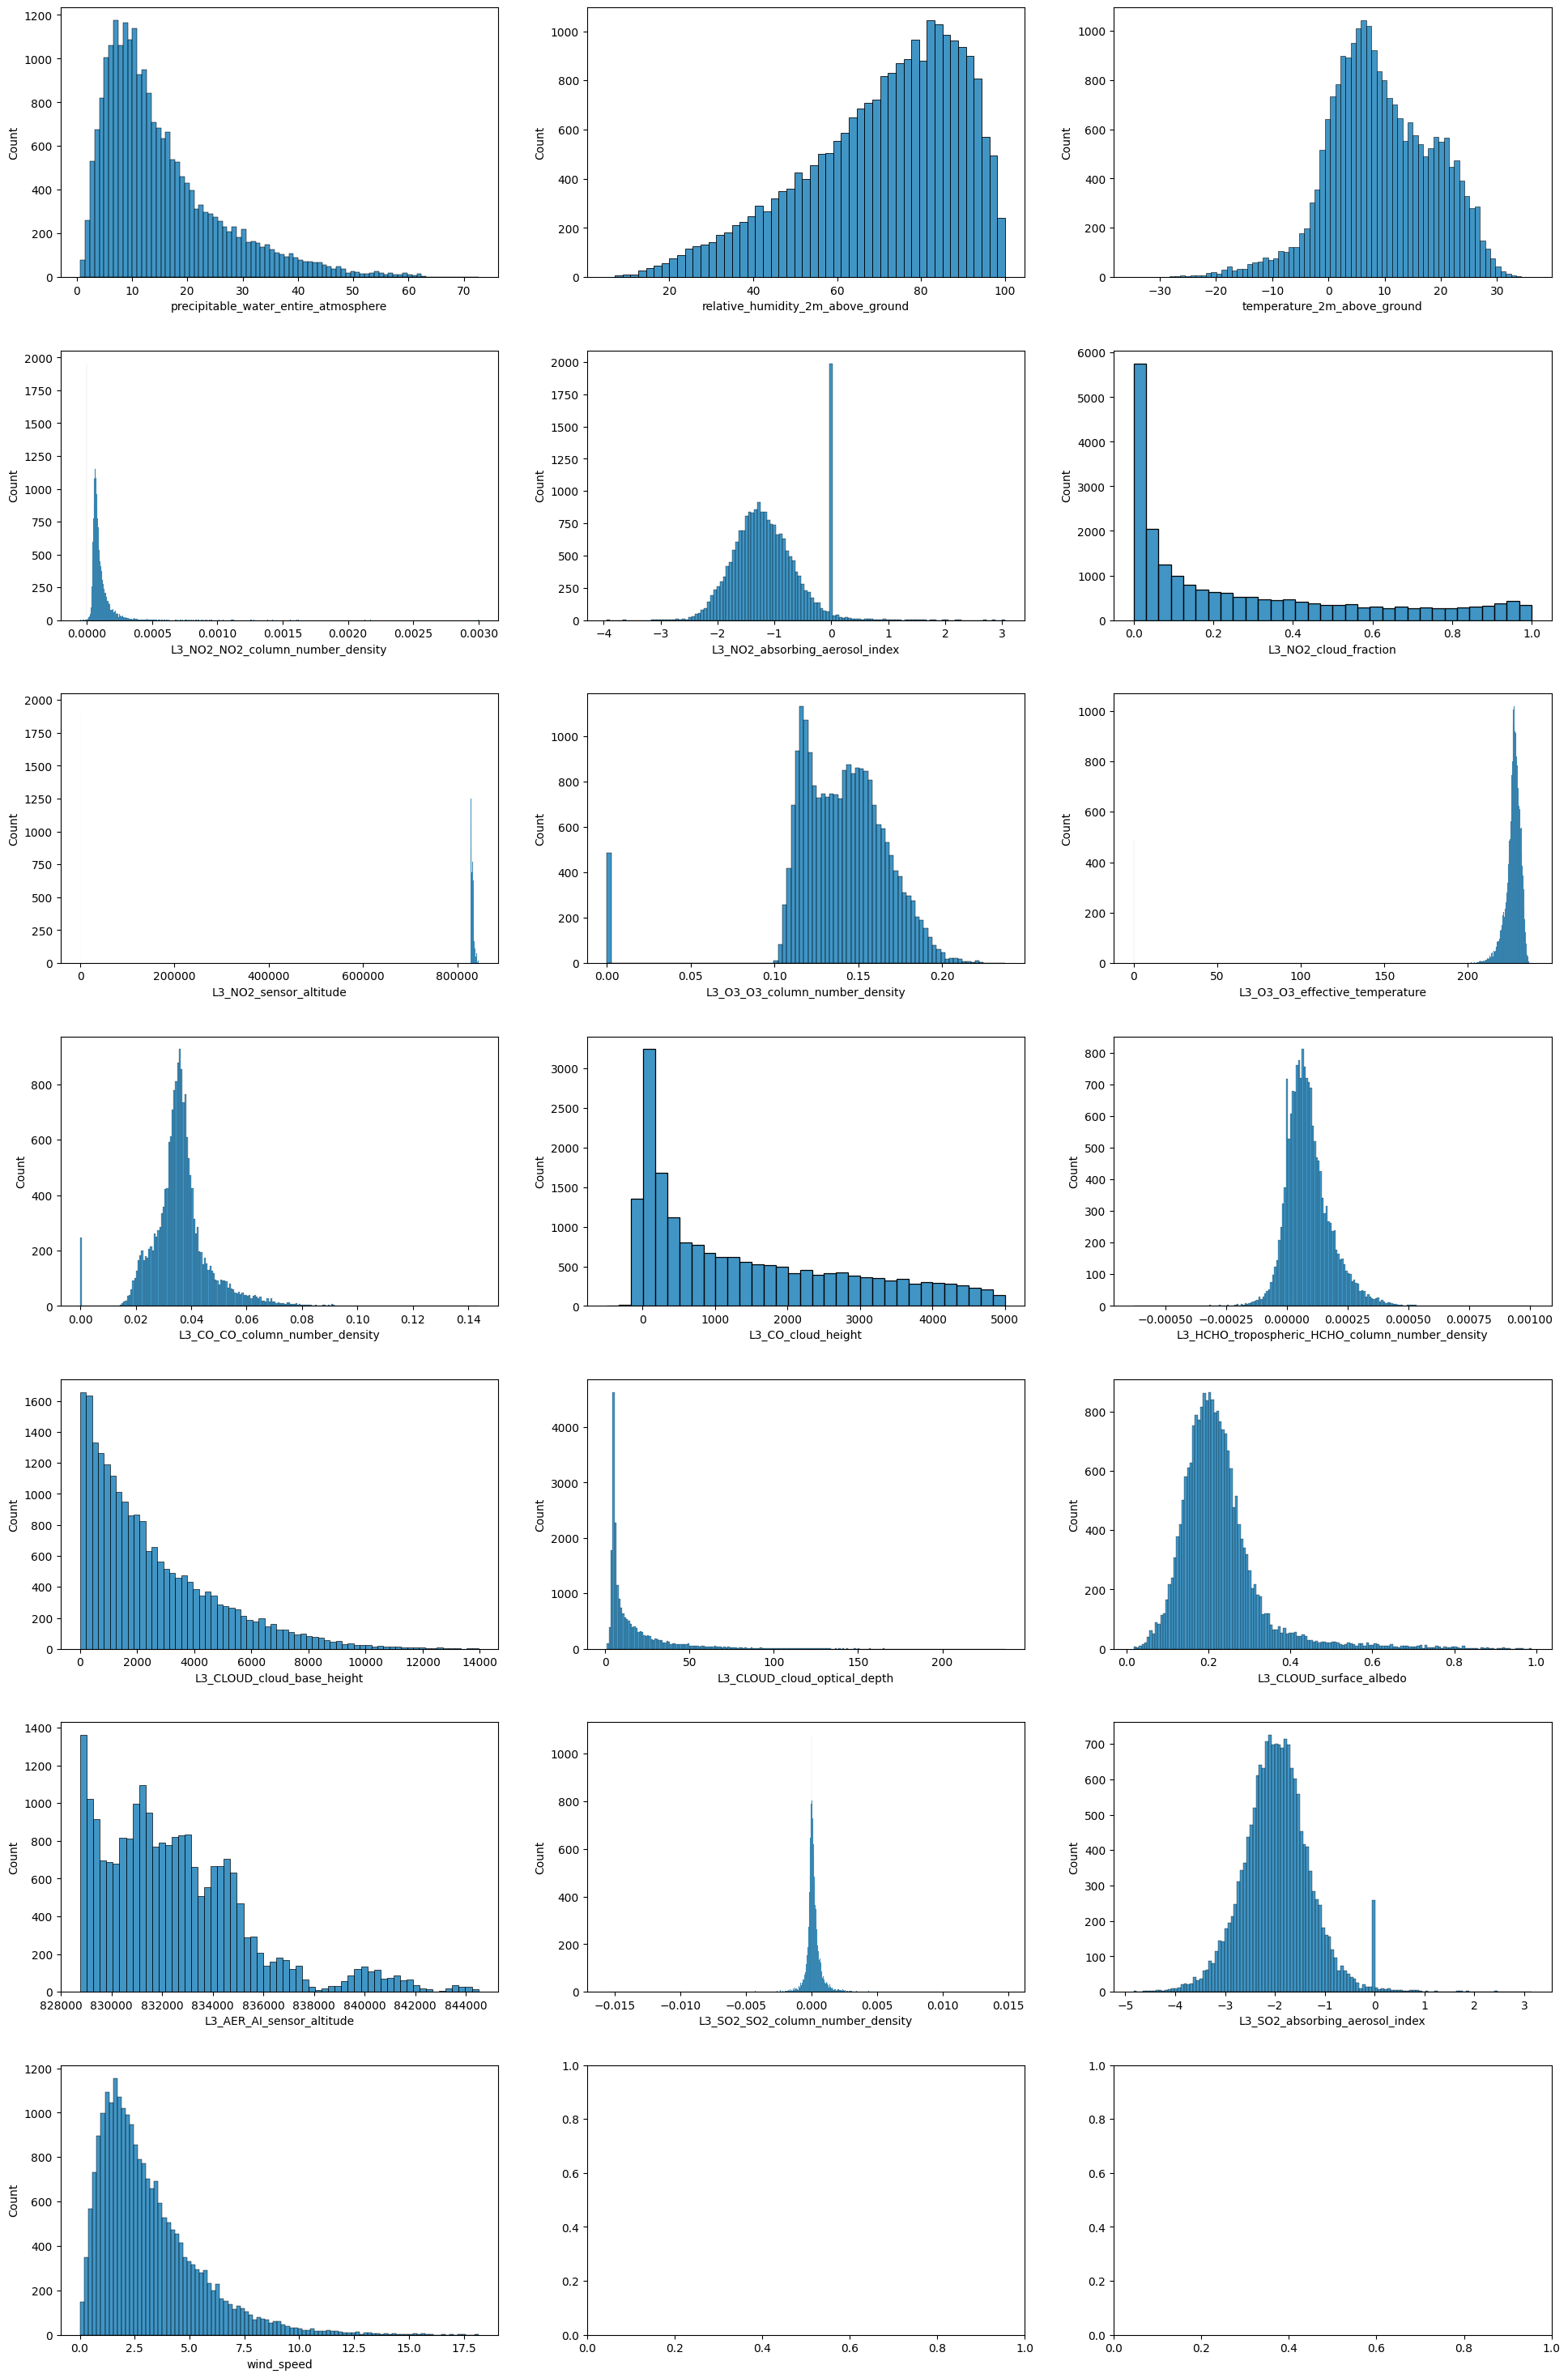

In [166]:
# visualize histograms of features to spot outliers or irregular distributions
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

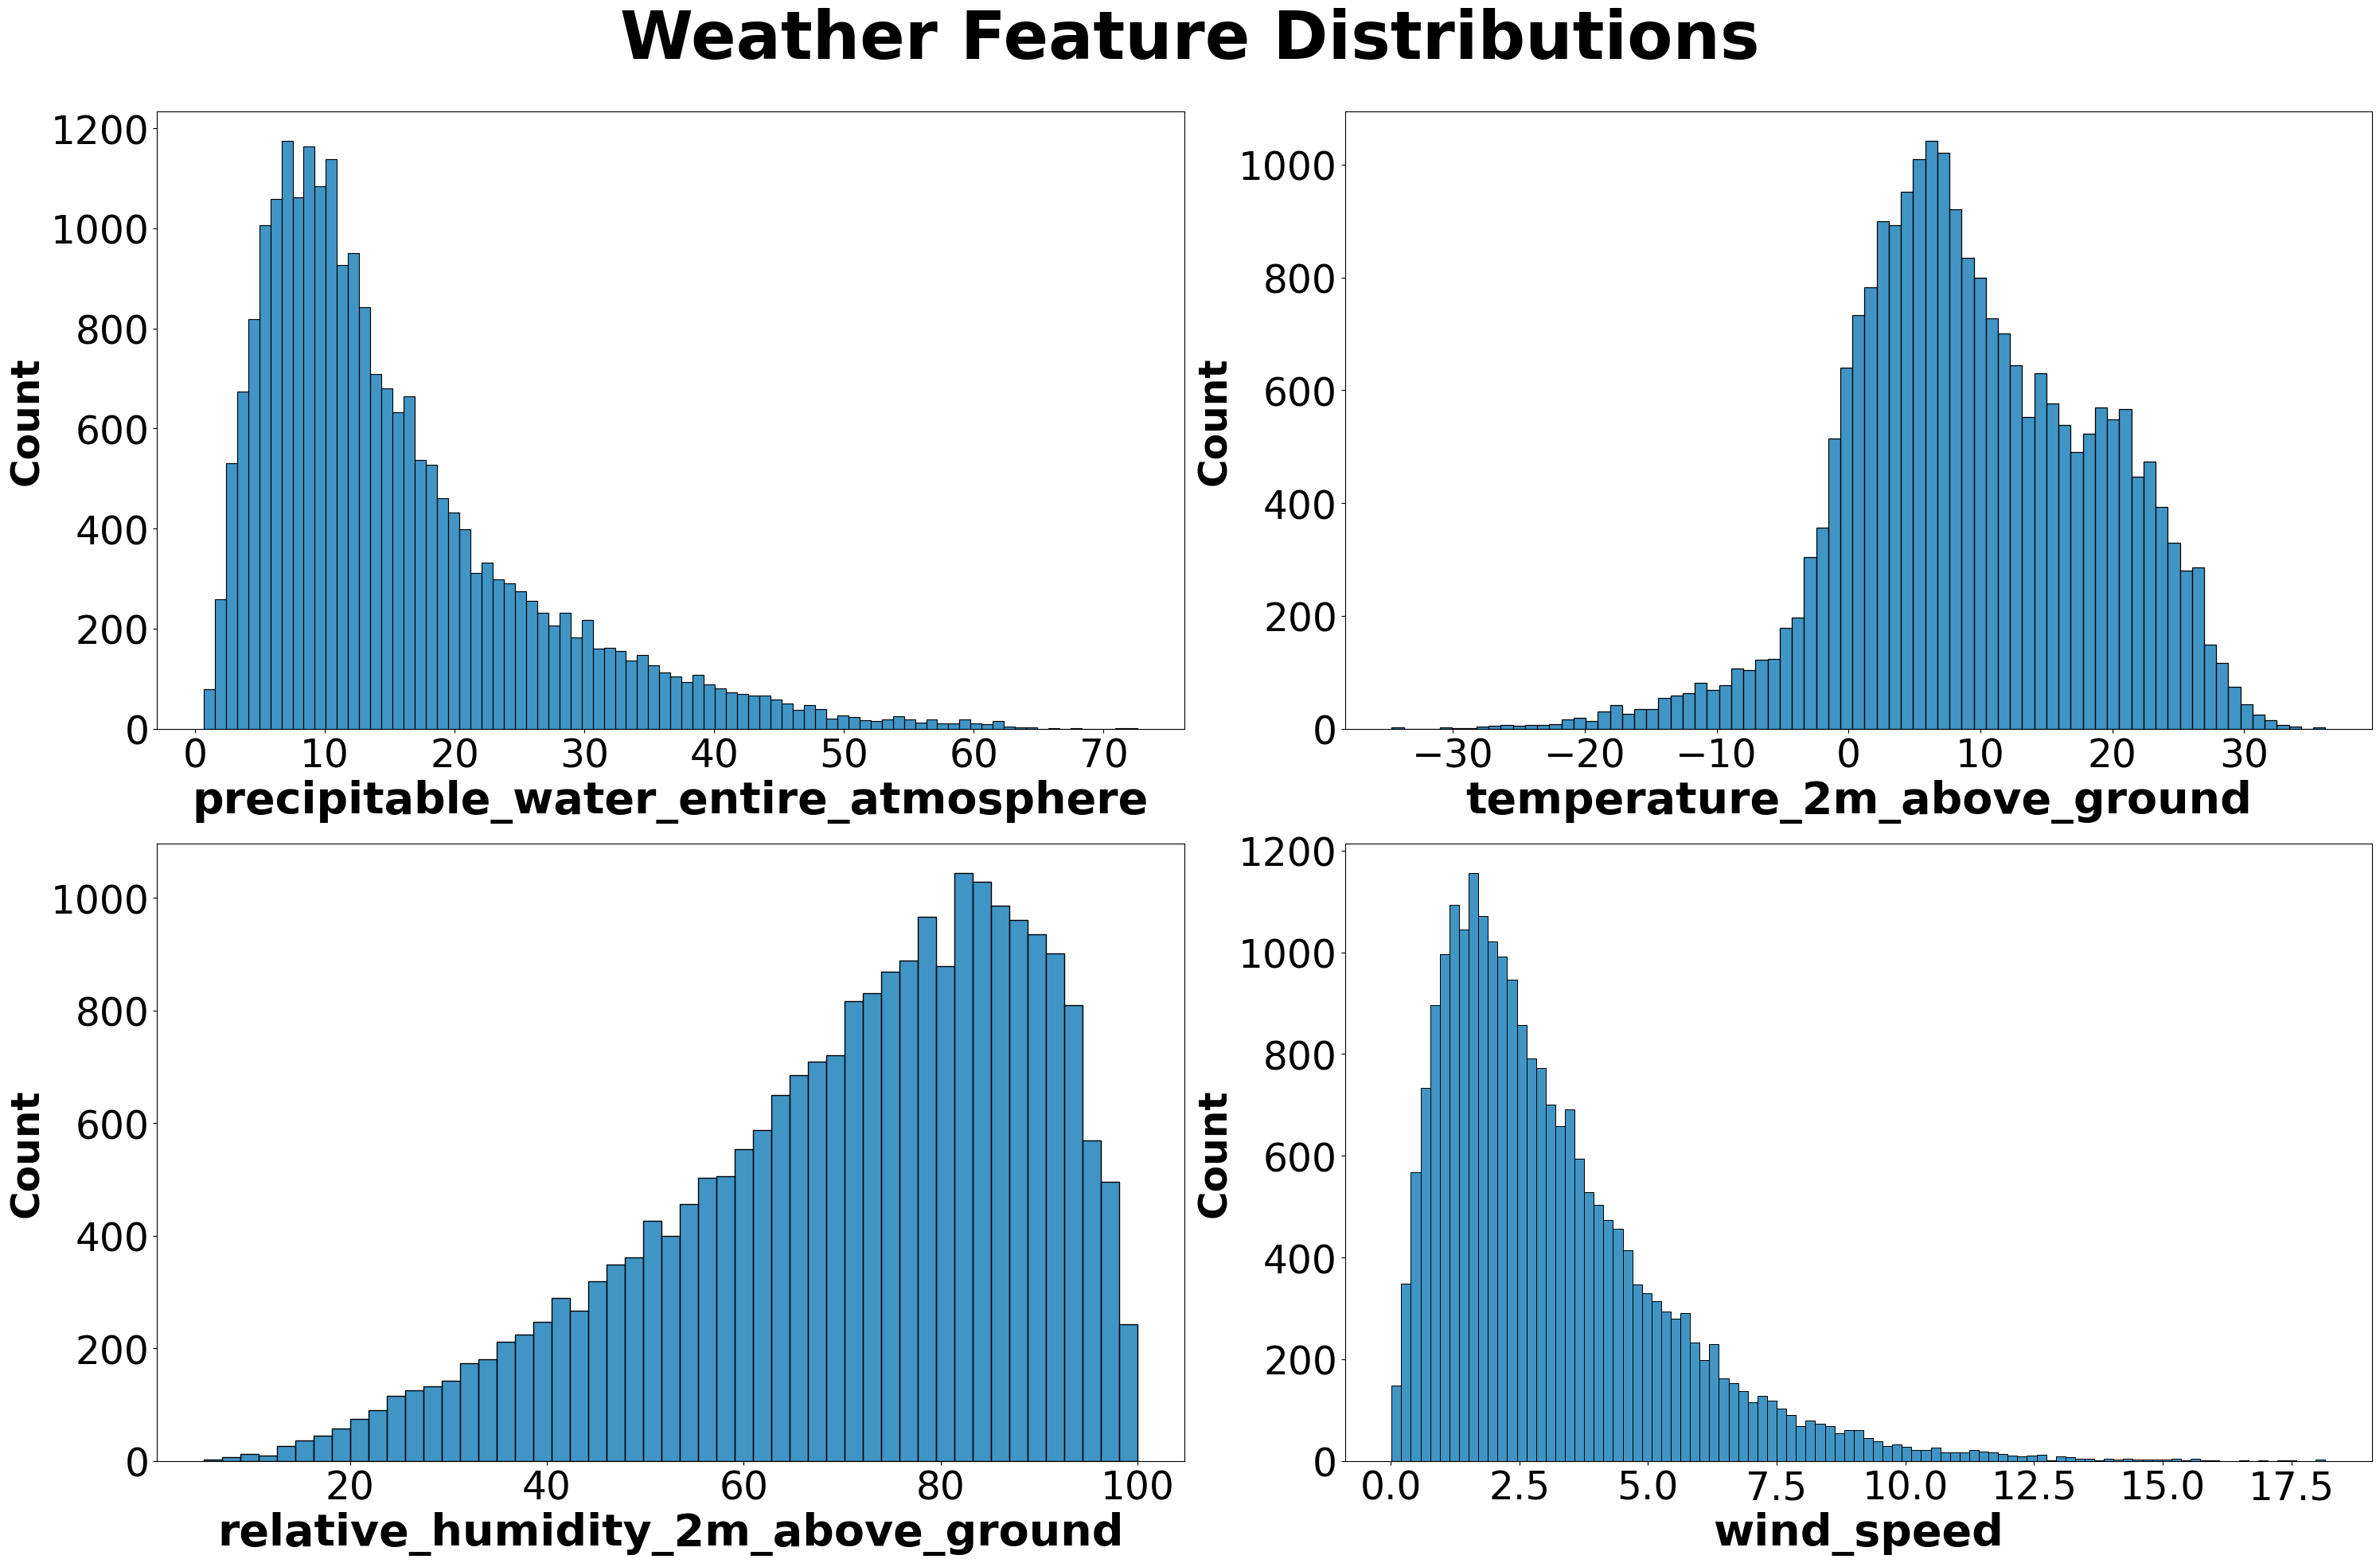

In [167]:
weather_col=df_train[['precipitable_water_entire_atmosphere','temperature_2m_above_ground','relative_humidity_2m_above_ground','wind_speed']]

fig, axes = plt.subplots(2, 2, figsize=(30, 20))
axes = axes.flatten()

for ax, col in zip(axes, weather_col):
    sns.histplot(df_train, x=col, ax=ax)
    ax.set_xlabel(col, fontsize=40,fontweight='bold')
    ax.set_ylabel("Count", fontsize=35,fontweight='bold')
    ax.tick_params(axis='both', labelsize=35)

fig.suptitle("Weather Feature Distributions", fontsize=60, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [11]:
# print descriptive metrics of features to spot outliers
for col in ['target'] + list(df_train.columns[8:]):
    print(f'''{col}
min, mean, max:           {df_train[col].min().round(3)}   {df_train[col].mean().round(3)}   {df_train[col].max().round(3)}
quantiles (25, 50, 75):   {df_train[col].quantile(0.25).round(3)}   {df_train[col].quantile(0.50).round(3)}   {df_train[col].quantile(0.75).round(3)}\n''')

target
min, mean, max:           1.0   61.231   470.0
quantiles (25, 50, 75):   25.0   50.0   80.0

precipitable_water_entire_atmosphere
min, mean, max:           0.664   15.299   72.6
quantiles (25, 50, 75):   7.611   12.2   19.9

relative_humidity_2m_above_ground
min, mean, max:           5.129   70.621   100.0
quantiles (25, 50, 75):   58.815   74.213   85.426

temperature_2m_above_ground
min, mean, max:           -34.648   9.3   36.162
quantiles (25, 50, 75):   3.055   8.457   16.219

L3_NO2_NO2_column_number_density
min, mean, max:           -0.0   0.0   0.003
quantiles (25, 50, 75):   0.0   0.0   0.0

L3_NO2_absorbing_aerosol_index
min, mean, max:           -3.942   -1.095   3.051
quantiles (25, 50, 75):   -1.514   -1.171   -0.745

L3_NO2_cloud_fraction
min, mean, max:           0.0   0.278   1.0
quantiles (25, 50, 75):   0.026   0.148   0.469

L3_NO2_sensor_altitude
min, mean, max:           0.0   756112.826   844493.898
quantiles (25, 50, 75):   829684.837   831602.982   833731

# Baseline Model

<Axes: xlabel='L3_CO_CO_column_number_density', ylabel='target'>

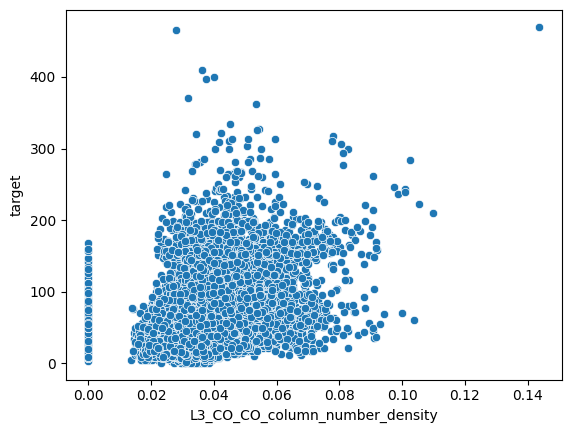

In [12]:
# scatterplot of feature with strongest correlation to target
sns.scatterplot(df_train, x='L3_CO_CO_column_number_density', y='target')

In [ ]:
def print_eval_metrics(y_test,y_pred, model_name):
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name:25s} Results")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

    return {'model': model_name, 'rmse': rmse, 'r2': r2}

In [52]:
# baseline model based on features associated with air pollution
def baseline_model(df, target_col, feature_cols=None, random_state=RSEED):
    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state) #, test_size=0.2

    # fill nan with median of train data
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # evaluation
    print_eval_metrics(y_test,y_pred,"Linear Regression")

    return model, y_pred


U = df['u_component_of_wind_10m_above_ground']
V = df['v_component_of_wind_10m_above_ground']
# 1) Wind speed (m/s)
df['wind_speed'] = np.hypot(U.to_numpy(), V.to_numpy())



print('\n-> based on feature with strongest correlation to target')
cols = ['L3_CO_CO_column_number_density']
model, preds = baseline_model(df, target_col='target', feature_cols=cols)

print('-> based on features associated with air pollution')
cols = ["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground", "wind_speed"] # add clouds?
model, preds = baseline_model(df, target_col="target", feature_cols=cols)


-> based on feature with strongest correlation to target
Linear Regression         Results
RMSE: 43.65
R²:   0.11
-> based on features associated with air pollution
Linear Regression         Results
RMSE: 43.50
R²:   0.12


In [16]:
# create list with all features that have weird bar at 0
peak_cols = [
    'L3_NO2_NO2_column_number_density',
    'L3_NO2_absorbing_aerosol_index',
    'L3_NO2_sensor_altitude',
    'L3_O3_O3_column_number_density',
    'L3_O3_O3_effective_temperature',
    'L3_CO_CO_column_number_density',
    "L3_SO2_absorbing_aerosol_index"
    ]

# replace 0s with nan
df_train[peak_cols] = df_train[peak_cols].replace(0, np.nan)
df_test[peak_cols] = df_test[peak_cols].replace(0, np.nan)


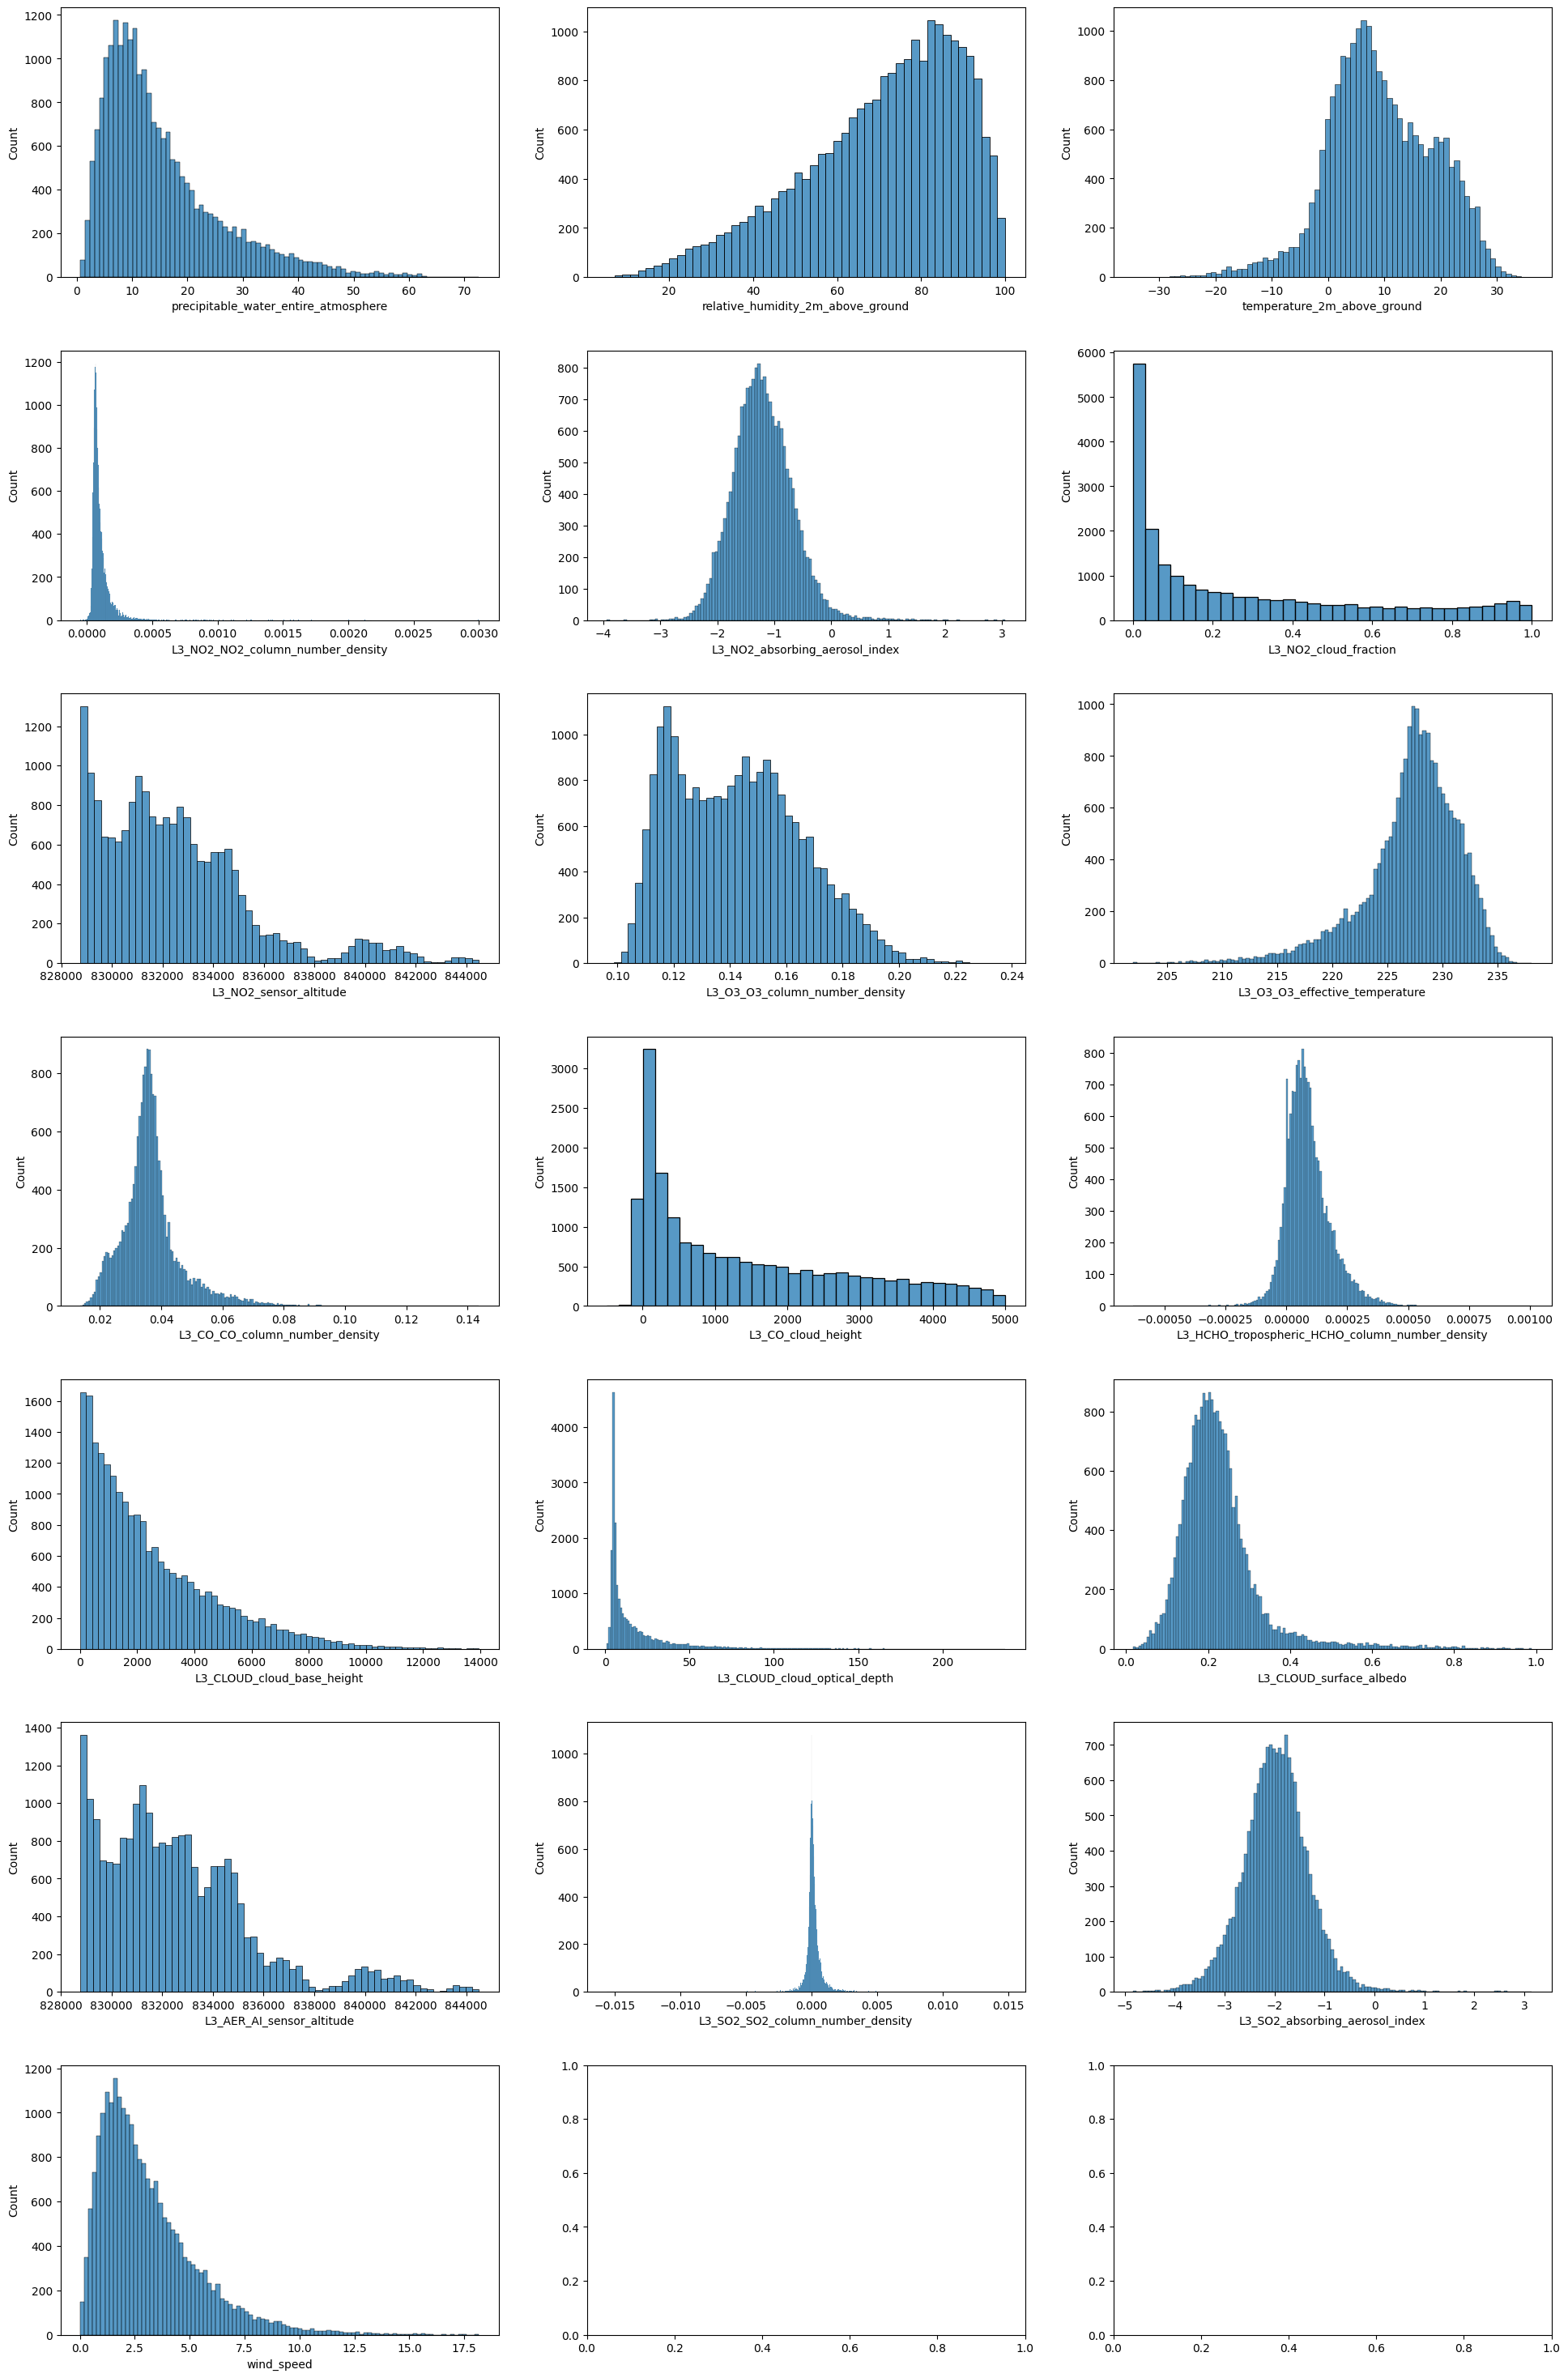

In [17]:
# visualize again to check skew after remove 0
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

# Pipeline

In [18]:
def clip_outliers(X, lower=0.01, upper=0.99):
    X_ = X.copy()
    q_low = X_.quantile(lower)
    q_high = X_.quantile(upper)
    return X_.clip(q_low, q_high, axis=1)

In [19]:
# define train and test data and exclude location columns, as well as descriptive metrics of target
cols_places = ['Place_ID X Date', 'Place_ID']
cols_target = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']

X_train = df_train.drop(cols_places + cols_target, axis=1)
X_test = df_test.drop(cols_places + cols_target, axis=1)
y_train = df_train['target']
y_test = df_test['target']

In [20]:
# select datetime cols
dt_cols = ['Date']

# select all numerical cols
num_cols = X_train.select_dtypes('number').columns.tolist()

# identify skewed cols
skew_thresh = 0.5
skew_cols2 = X_train[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skew_cols = skew_cols2[abs(skew_cols2) > skew_thresh].index.tolist()

# only select numerical cols which arent skewed
num_cols = list(set(num_cols) - set(skew_cols))


print(f"{len(dt_cols)}      dt cols: {dt_cols}...{type(dt_cols)}")
print(f"{len(skew_cols)} skewed cols: {skew_cols}")
print(f"{len(num_cols)}     num cols:",num_cols)


1      dt cols: ['Date']...<class 'list'>
15 skewed cols: ['L3_NO2_NO2_column_number_density', 'L3_CLOUD_cloud_optical_depth', 'L3_CLOUD_surface_albedo', 'wind_speed', 'L3_CO_CO_column_number_density', 'precipitable_water_entire_atmosphere', 'L3_CLOUD_cloud_base_height', 'L3_NO2_sensor_altitude', 'L3_AER_AI_sensor_altitude', 'L3_NO2_cloud_fraction', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_CO_cloud_height', 'L3_NO2_absorbing_aerosol_index', 'relative_humidity_2m_above_ground', 'L3_O3_O3_effective_temperature']
4     num cols: ['L3_SO2_SO2_column_number_density', 'L3_O3_O3_column_number_density', 'temperature_2m_above_ground', 'L3_SO2_absorbing_aerosol_index']


### compare models
- LinearRegression() - baseline
- Ridge() - baseline, handles collinearity
- Lasso() - find important features
- ElasticNet() - ridge+lasso: when correl features + find important feature
- RandomForestRegressor() - 
- GradientBoostingRegressor() - better accuracy than randomforest
- XGBoost() - fast, powerful
- LightGBM


In [112]:
# custom transformer - aka preprocessor encoder class for datetime
# ------------------------------------------
# split datetime into its components and add as feature
# capture cyclic nature of dayofweek with sin/cos
#   > important for LinRegression, NN
#   > not important (but not harmful either) for trees
class CyclicDatetimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_cols):
        self.datetime_cols = datetime_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.datetime_cols:
            dt = X_[col]
            # simple calendar features
            X_[f"{col}_month"] = dt.dt.month
            X_[f"{col}_day"] = dt.dt.day
            X_[f"{col}_dayofweek"] = dt.dt.dayofweek
            X_[f"{col}_is_weekend"] = dt.dt.dayofweek.isin([5,6]).astype(int)

            # cyclic encoding for dayofweek
            X_[f"{col}_dow_sin"] = np.sin(2 * np.pi * dt.dt.dayofweek / 7)
            X_[f"{col}_dow_cos"] = np.cos(2 * np.pi * dt.dt.dayofweek / 7)

            X_.drop(columns=[col], inplace=True)
        return X_


    def get_feature_names_out(self, input_features=None):
        ##Called by ColumnTransformer to obtain output column names.
        ##`input_features` will be the columns ColumnTransformer passed to this transformer.
        cols = list(input_features) if input_features is not None else self.input_features_
        outs = []
        for col in cols:
            outs.extend([
                f"{col}_month",
                f"{col}_day",
                f"{col}_dayofweek",
                f"{col}_is_weekend",
                f"{col}_dow_sin",
                f"{col}_dow_cos",])
        return np.array(outs, dtype=object)

    # TransformerMixin:
    # - auto generate fit_transform
    # - to work seamless with pipelines
    # BaseEstimator:
    # - provides some standard methods: .get_params(), .set_params(), ...
    # - for Hyperparam tuning (eg GridSearchCV)


In [113]:
# only run datetime preprocess for testing/bugfix
encoder = CyclicDatetimeEncoder(dt_cols)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.transform(X_test)

In [114]:
prep_linreg = ColumnTransformer([
    ('skewed', Pipeline([
        # ('clip', FunctionTransformer(clip_outliers)),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', RobustScaler())
    ]), skew_cols),

    ('normal', Pipeline([
        # ('clip', FunctionTransformer(clip_outliers)),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler())
    ]), num_cols),

    ('datetime', CyclicDatetimeEncoder(dt_cols), dt_cols),
])

prep_tree = ColumnTransformer([
    ('num', KNNImputer(n_neighbors=5), num_cols + skew_cols),
    ('datetime', CyclicDatetimeEncoder(dt_cols), dt_cols),
])

### pipelines using linreg preprocessor
linreg = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', LinearRegression())
])

elastic = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=RSEED))
])

ridge = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', Ridge(alpha=1.0, random_state=RSEED))
])

lasso = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', Lasso(alpha=1.0, max_iter=10000, random_state=RSEED))
])


### pipelines using tree preprocessor
tree_gbr = Pipeline([
    ('preprocessor', prep_tree),
    ('model', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,     # Shrinkage (lower = more conservative)
            max_depth=3,           # Shallow trees work best (3-5)
            min_samples_split=5,
            min_samples_leaf=2,
            subsample=0.8,         # Row sampling (0.5-1.0)
            random_state=RSEED
        ))
])

tree_xgb = Pipeline([
    ('preprocessor', prep_tree),
    ('model', XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,    # Min sum of weights in child
            subsample=0.8,         # Row sampling
            colsample_bytree=0.8,  # Column sampling
            random_state=RSEED,
            n_jobs=-1
    ))
])

tree_rf = Pipeline([
    ('preprocessor', prep_tree),
    ('model', RandomForestRegressor(
    n_estimators=120,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt', #log2
    random_state=RSEED,
    n_jobs=-1))
])




In [51]:
### run all pipelines
from sklearn.base import clone
models = [linreg,ridge,elastic,lasso,tree_rf,tree_gbr,tree_xgb]
results = []
y_preds={}
for i, model in enumerate(models):
    modelname = model.named_steps['model'].__class__.__name__
    print(f"\nrunning pipeline #{i+1}/{len(models)} for {modelname}")

    mdl = clone(model)                    # fresh copy
    mdl.fit(X_train, y_train)             # fit THIS model
    y_pred = mdl.predict(X_test)          # predict with THIS model
    y_preds[modelname] = y_pred
    # evaluation
    res = print_eval_metrics(y_test,y_pred,modelname)
    results.append(res)





running pipeline #1/7 for LinearRegression
LinearRegression          Results
RMSE: 35.62
R²:   0.39

running pipeline #2/7 for Ridge
Ridge                     Results
RMSE: 35.62
R²:   0.39

running pipeline #3/7 for ElasticNet
ElasticNet                Results
RMSE: 37.14
R²:   0.34

running pipeline #4/7 for Lasso
Lasso                     Results
RMSE: 36.01
R²:   0.38

running pipeline #5/7 for RandomForestRegressor
RandomForestRegressor     Results
RMSE: 28.81
R²:   0.60

running pipeline #6/7 for GradientBoostingRegressor
GradientBoostingRegressor Results
RMSE: 32.08
R²:   0.50

running pipeline #7/7 for XGBRegressor
XGBRegressor              Results
RMSE: 32.06
R²:   0.51


In [ ]:
# Analyze results
results_df = pd.DataFrame(results)
# print(results_df.sort_values('r2', ascending=False))
print("=== RESULTS SUMMARY SORTED BY RSME ===")
print(results_df.sort_values('rmse'))

=== RESULTS SUMMARY SORTED BY RSME ===
                       model       rmse        r2
4      RandomForestRegressor  28.868747  0.598783
6               XGBRegressor  32.161476  0.502039
5  GradientBoostingRegressor  32.227964  0.499978
0           LinearRegression  35.615749  0.389329
1                      Ridge  35.615779  0.389328
3                      Lasso  36.013429  0.375616
2                 ElasticNet  37.138190  0.336006


=== RESULTS SUMMARY SORTED BY RSME ===
                       model       rmse        r2
4      RandomForestRegressor  30.435188  0.554062
6               XGBRegressor  33.387024  0.463366
5  GradientBoostingRegressor  33.535533  0.458581
1                      Ridge  37.610593  0.319006
0           LinearRegression  37.610603  0.319006
3                      Lasso  38.014318  0.304307
2                 ElasticNet  38.865876  0.272790


### with clip (linreg only)
```
LinearRegression Results << clip 2% all
RMSE: 37.444
R²:   0.325

LinearRegression Results << clip 1% all
RMSE: 38.036
R²:   0.304

LinearRegression Results << without clip
RMSE: 37.382
R²:   0.327
```


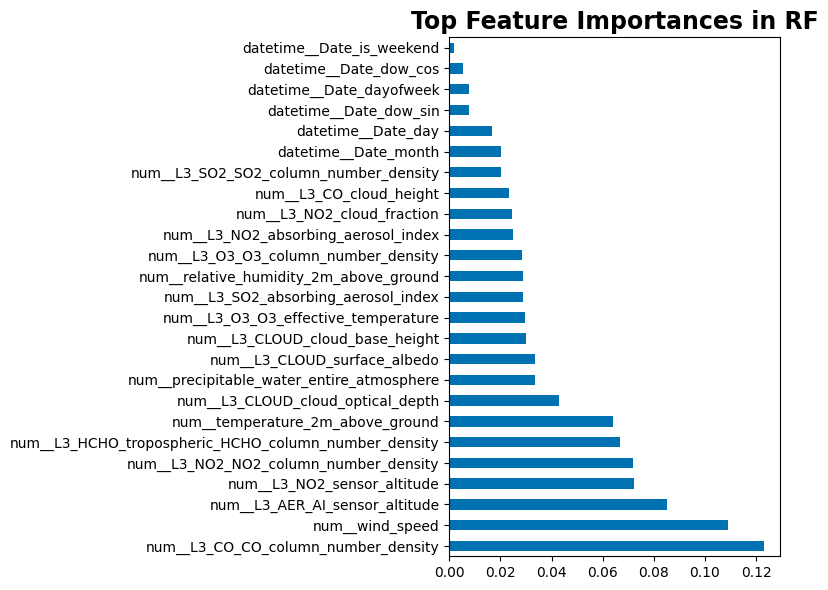

0.7023520201701328

In [117]:
# plot feature importance (for tree models only)

rf_pipe = clone(tree_rf)
rf_pipe.fit(X_train, y_train)

rf = rf_pipe.named_steps['model']
feature_names = rf_pipe.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names)
importances.nlargest(30).plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances in RF",fontsize=17, fontweight="bold")
plt.tight_layout()
plt.show()

# top 5 RF:
# skewed__L3_CO_CO_column_number_density              0.143631
# skewed__L3_NO2_NO2_column_number_density            0.089796
# skewed__L3_AER_AI_sensor_altitude                   0.086519
# normal__L3_HCHO_HCHO_slant_column_number_density    0.078402
# skewed__L3_NO2_sensor_altitude                      0.069834
importances.nlargest(10).sum()

Since RandomForestRegressor won, lets tune its hyperparams!
Too speed things up, lets
- run the tree-preprocessing steps individually 
- then subsample data

In [ ]:
# preprocess data outside of pipeline
X_train_prep = prep_tree.fit_transform(X_train)
X_test_prep  = prep_tree.transform(X_test)

# subsample to save time during GridSeachCV
X_train_sample = X_train.sample(frac=0.3, random_state=RSEED)
y_train_sample = y_train.loc[X_train_sample.index]

# preprocess sampled train data
X_train_sample_prep = prep_tree.fit_transform(X_train_sample)

In [ ]:
def param_range(center, step_size, n_steps_each_side=2, min_val=1):
    start = max(center - n_steps_each_side * step_size, min_val)
    end = center + n_steps_each_side * step_size
    return list(range(start, end + step_size, step_size))

In [ ]:
# RandomForestRegressor hyperparameter tuning with Randomized- & Grid-SearchC
param_grid_randCV = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [3, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

from joblib import parallel_backend

with parallel_backend("threading"):
    randCV = RandomizedSearchCV(
        RandomForestRegressor(random_state=RSEED, n_jobs=-1),  # RF itself parallelizes
        param_grid_randCV,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,   # threads for the CV outer loop
        random_state=RSEED,
        verbose=0
    )
    randCV.fit(X_train_prep, y_train)
best_params = randCV.best_params_
print('Best params RandomSearchCV:', best_params)


param_grid_gridCV = {
    'n_estimators': param_range(best_params['n_estimators'], 20),
    'max_depth': param_range(best_params['max_depth'], 5),
    'min_samples_split': param_range(best_params['min_samples_split'], 1, min_val=2),
    'min_samples_leaf': param_range(best_params['min_samples_leaf'], 1),
    'max_features': [best_params['max_features']]
}
with parallel_backend("threading"):
    gridCV = GridSearchCV(
        RandomForestRegressor(random_state=RSEED),
        param_grid_gridCV,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1)
    gridCV.fit(X_train_sample_prep,y_train_sample)
best_params = gridCV.best_params_
print('Best params GridSearchCV:', best_params)


best_estimator = gridCV.best_estimator_

KeyboardInterrupt: 

In [ ]:
best_estimator = gridCV.best_estimator_
best_estimator.fit(X_train_prep, y_train)
y_pred = best_estimator.predict(X_test_prep)
print_eval_metrics(y_test, y_pred, 'RandomForestRegressor')

RandomForestRegressor     Results
RMSE: 28.71
R²:   0.60


{'model': 'RandomForestRegressor',
 'rmse': 28.709052109374458,
 'r2': 0.6032100313803695}

In [ ]:
# model.named_steps['preprocessor'].get_feature_names_out()

In [ ]:
# how-to visualize post/in-pipe to see prep changes?

### MIXTURE OF EXPERTS
![](https://media.brightdata.com/2025/05/What-is-MoE_.png)

### EXPERTS OF ZONE, POLLUTION, WIND SPEED AND URBAN/RURAL AREA

| **Zone**        | **Typical conditions (Jan–Apr)**                                                                          | **How temperature, moisture, and wind affect it**                                                                                                                                                                                                |
| --------------- | --------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 🌨 **Polar**    | Very cold, icy, or freezing weather. The air is dry, and sometimes strong winds make it feel even colder. | - Below **–5 °C** → always polar.<br>- Around **0 °C** but still **dry (PWAT < 10)** → polar.<br>- Even **0–3 °C** can count if **wind ≥ 8 m/s** — windchill makes it feel polar.                                                                |
| 🏜 **Desert**   | Hot and dry days, or sometimes warm and dusty with strong winds.                                          | - Usually **≥ 16 °C** and **very dry (PWAT < 8)**.<br>- Also counts if **~14–16 °C**, **very dry (PWAT < 6)** and **wind ≥ 12 m/s** — typical dusty or arid weather.<br>- If it’s **very hot (≥ 28 °C)** and **dry (PWAT < 12)**, always desert. |
| 🌴 **Tropical** | Warm, humid air — feels sticky or heavy, even in early months of the year.                                | - Around **22 °C or warmer** and **PWAT ≥ 12**, meaning lots of moisture in the air.<br>- Wind doesn’t matter much here.                                                                                                                         |
| ☀️ **Summer**   | Pleasantly warm weather — not too dry, not too humid.                                                     | - If **wind < 8 m/s**, anything **≥ 19 °C** feels like summer.<br>- If it’s windier (**≥ 8 m/s**), it needs to be a bit warmer (**≥ 21 °C**) to still feel summery.                                                                              |
| ❄️ **Winter**   | Cool to cold weather that doesn’t reach freezing extremes.                                                | - Anything cooler than the “summer” thresholds but not cold enough for polar.<br>- Can be damp or breezy, typical of late winter or early spring days.                                                                                           |


In [82]:
# === set your column names here ===
NO2_COL  = 'L3_NO2_NO2_column_number_density'
CO_COL = 'L3_CO_CO_column_number_density'        # your PM2.5 concentration
TEMP_COL = 'temperature_2m_above_ground'
PWAT_COL = 'precipitable_water_entire_atmosphere'
HCHO_COL= 'L3_HCHO_tropospheric_HCHO_column_number_density'
WIND_COL = 'wind_speed'  # or whatever your column is named


df_train['wind_bin'] = pd.cut(
    df_train[WIND_COL],
    bins   = [0, 3, 8, 12, float('inf')],
    labels = ['light', 'breezy', 'windy', 'very windy'],
    right=False,          # left-closed, right-open
    include_lowest=True
)

if df_train['wind_bin'].isna().any():
    if 'unknown' not in df_train['wind_bin'].cat.categories:
        df_train['wind_bin'] = df_train['wind_bin'].cat.add_categories('unknown')
    df_train['wind_bin'] = df_train['wind_bin'].fillna('unknown')

# --- 1) NO2 bins: rural / peri-urban / urban ---
# Intervals: [-inf, 1e-4), [1e-4, 3e-4), [3e-4, inf)
df_train['no2_bin'] = pd.cut(
    df_train[NO2_COL],
    bins=[-np.inf, 1e-4, 3e-4, np.inf],
    labels=['rural', 'peri-urban', 'urban'],
    right=False,             # left-closed, right-open; 0.0003 -> 'urban'
    include_lowest=True
)

if df_train['no2_bin'].isna().any():
    if 'unknown' not in df_train['no2_bin'].cat.categories:
        df_train['no2_bin'] = df_train['no2_bin'].cat.add_categories('unknown')
    df_train['no2_bin'] = df_train['no2_bin'].fillna('unknown')

# --- 2) PM2.5 bins from your target thresholds ---
# Bins: (-inf,15], (15,35], (35,55], (55,150], (150,200], (200,inf)
df_train['co_bin'] = pd.cut(
    df_train[CO_COL],
    bins  = [0.0, 0.04, 0.08, np.inf],
    labels = ['low_co','moderate_co','high_co'],
    right=False,              # 0.2 -> 'extreme'
    include_lowest=True
)

if df_train['co_bin'].isna().any():
    if 'unknown' not in df_train['co_bin'].cat.categories:
        df_train['co_bin'] = df_train['co_bin'].cat.add_categories('unknown')
    df_train['co_bin'] = df_train['co_bin'].fillna('unknown')



df_train['voc_bin'] = pd.cut(
    df_train[HCHO_COL],
    bins  = [-np.inf, -1e-4, 1e-4, 4e-4, np.inf], 
    labels = ['neg_noise', 'background', 'low', 'high'], 
    right=False,
    include_lowest=True
)

# Optional: add explicit 'unknown' for NaNs
if df_train['voc_bin'].isna().any():
    if 'unknown' not in df_train['voc_bin'].cat.categories:
        df_train['voc_bin'] = df_train['voc_bin'].cat.add_categories('unknown')
    df_train.loc[df_train[HCHO_COL].isna(), 'voc_bin'] = 'unknown'




cond = [
    # POLAR: very cold or near-freezing & dry; wind ≥ 8 pushes 0–3 °C dry cases into polar
    (df_train[TEMP_COL] < -5) |
    ((df_train[TEMP_COL] <= 0) & (df_train[PWAT_COL] < 10)) |
    (((df_train[TEMP_COL] > 0) & (df_train[TEMP_COL] <= 3)) & (df_train[PWAT_COL] < 12) & (df_train[WIND_COL] >= 8)),

    # DESERT: dry + warm/hot; allow slightly cooler if ultra-dry and wind ≥ 12
    ((df_train[TEMP_COL] >= 16) & (df_train[PWAT_COL] < 8)) |
    ((df_train[TEMP_COL] >= 28) & (df_train[PWAT_COL] < 12)) |
    (((df_train[TEMP_COL] >= 14) & (df_train[TEMP_COL] <= 16)) & (df_train[PWAT_COL] < 6) & (df_train[WIND_COL] >= 12)),

    # TROPICAL: warm + moist
    (df_train[TEMP_COL] >= 22) & (df_train[PWAT_COL] >= 12),

    # SUMMER: warm leftover; if wind ≥ 8, require 21 °C; else 19 °C
    ((df_train[WIND_COL] < 8)  & (df_train[TEMP_COL] >= 19)) |
    ((df_train[WIND_COL] >= 8) & (df_train[TEMP_COL] >= 21)),

    # WINTER: catch-all for any remaining non-NaN temps
    df_train[TEMP_COL].notna(),
]

choice = ['polar', 'desert', 'tropical', 'summer', 'winter']
df_train['zone'] = np.select(cond, choice, default='unknown')


# --- 4) Make them categorical (memory- and groupby-friendly) ---
for c in ['no2_bin', 'co_bin', 'zone','voc_bin','wind_bin']:
    df_train[c] = df_train[c].astype('category')



# --- 5) Quick sanity checks (optional) ---
#print(df_test.isna().mean())
print("NaN rates for routing columns:\n", df_train[['no2_bin','co_bin','zone','voc_bin']].isna().mean())
print("\nno2_bin counts:\n", df_train['no2_bin'].value_counts(dropna=False))
print("\nco_bin counts:\n", df_train['co_bin'].value_counts(dropna=False))
print("\nzone counts:\n", df_train['zone'].value_counts(dropna=False))
print("\nvoc counts:\n", df_train['voc_bin'].value_counts(dropna=False))
print("\nwind counts:\n", df_train['wind_bin'].value_counts(dropna=False))
#print(df_test.loc[df['no2_bin'].isna(), [NO2_COL]].head(10))


print(df_train.info())

NaN rates for routing columns:
 no2_bin    0.0
co_bin     0.0
zone       0.0
voc_bin    0.0
dtype: float64

no2_bin counts:
 no2_bin
rural         12819
peri-urban     6034
unknown        3589
urban           470
Name: count, dtype: int64

co_bin counts:
 co_bin
low_co         13979
moderate_co     4521
unknown         4346
high_co           66
Name: count, dtype: int64

zone counts:
 zone
winter      15736
polar        2995
tropical     2243
summer       1779
desert        159
Name: count, dtype: int64

voc counts:
 voc_bin
background    10661
low            6408
unknown        5551
neg_noise       183
high            109
Name: count, dtype: int64

wind counts:
 wind_bin
light         13382
breezy         8640
windy           782
very windy      108
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 32 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------          

In [83]:
df_test['wind_bin'] = pd.cut(
    df_test[WIND_COL],
    bins   = [0, 3, 8, 12, float('inf')],
    labels = ['light', 'breezy', 'windy', 'very windy'],
    right=False,          # left-closed, right-open
    include_lowest=True
)

if df_test['wind_bin'].isna().any():
    if 'unknown' not in df_test['wind_bin'].cat.categories:
        df_test['wind_bin'] = df_test['wind_bin'].cat.add_categories('unknown')
    df_test['wind_bin'] = df_test['wind_bin'].fillna('unknown')

# --- 1) NO2 bins: rural / peri-urban / urban ---
# Intervals: [-inf, 1e-4), [1e-4, 3e-4), [3e-4, inf)
df_test['no2_bin'] = pd.cut(
    df_test[NO2_COL],
    bins=[-np.inf, 1e-4, 3e-4, np.inf],
    labels=['rural', 'peri-urban', 'urban'],
    right=False,             # left-closed, right-open; 0.0003 -> 'urban'
    include_lowest=True
)

if df_test['no2_bin'].isna().any():
    if 'unknown' not in df_test['no2_bin'].cat.categories:
        df_test['no2_bin'] = df_test['no2_bin'].cat.add_categories('unknown')
    df_test['no2_bin'] = df_test['no2_bin'].fillna('unknown')

# --- 2) CO bins from your target thresholds ---
df_test['co_bin'] = pd.cut(
    df_test[CO_COL],
    bins  = [0.0, 0.04, 0.08, np.inf],
    labels = ['low_co','moderate_co','high_co'],
    right=False,
    include_lowest=True
)

if df_test['co_bin'].isna().any():
    if 'unknown' not in df_test['co_bin'].cat.categories:
        df_test['co_bin'] = df_test['co_bin'].cat.add_categories('unknown')
    df_test['co_bin'] = df_test['co_bin'].fillna('unknown')

df_test['voc_bin'] = pd.cut(
    df_test[HCHO_COL],
    bins  = [-np.inf, -1e-4, 1e-4, 4e-4, np.inf], 
    labels = ['neg_noise', 'background', 'low', 'high'], 
    include_lowest=True
)

# Optional: add explicit 'unknown' for NaNs
if df_test['voc_bin'].isna().any():
    if 'unknown' not in df_test['voc_bin'].cat.categories:
        df_test['voc_bin'] = df_test['voc_bin'].cat.add_categories('unknown')
    df_test.loc[df_test[HCHO_COL].isna(), 'voc_bin'] = 'unknown'

# --- 3) Zone label (no "tropical_desert" helper; direct rules) ---
cond = [
    # POLAR: very cold or near-freezing & dry; wind ≥ 8 pushes 0–3 °C dry cases into polar
    (df_test[TEMP_COL] < -5) |
    ((df_test[TEMP_COL] <= 0) & (df_test[PWAT_COL] < 10)) |
    (((df_test[TEMP_COL] > 0) & (df_test[TEMP_COL] <= 3)) & (df_test[PWAT_COL] < 12) & (df_test[WIND_COL] >= 8)),

    # DESERT: dry + warm/hot; allow slightly cooler if ultra-dry and wind ≥ 12
    ((df_test[TEMP_COL] >= 16) & (df_test[PWAT_COL] < 8)) |
    ((df_test[TEMP_COL] >= 28) & (df_test[PWAT_COL] < 12)) |
    (((df_test[TEMP_COL] >= 14) & (df_test[TEMP_COL] <= 16)) & (df_test[PWAT_COL] < 6) & (df_test[WIND_COL] >= 12)),

    # TROPICAL: warm + moist
    (df_test[TEMP_COL] >= 22) & (df_test[PWAT_COL] >= 12),

    # SUMMER: warm leftover; if wind ≥ 8, require 21 °C; else 19 °C
    ((df_test[WIND_COL] < 8)  & (df_test[TEMP_COL] >= 19)) |
    ((df_test[WIND_COL] >= 8) & (df_test[TEMP_COL] >= 21)),

    # WINTER: catch-all for any remaining non-NaN temps
    df_test[TEMP_COL].notna(),
]

choice = ['polar', 'desert', 'tropical', 'summer', 'winter']
df_test['zone'] = np.select(cond, choice, default='unknown')

# --- 4) Make them categorical (memory- and groupby-friendly) ---
for c in ['no2_bin', 'co_bin', 'zone','voc_bin']:
    df_test[c] = df_test[c].astype('category')

# --- 5) Quick sanity checks (optional) ---
# print(df_test.isna().mean())
print("NaN rates for routing columns:\n", df_test[['no2_bin','co_bin','zone','voc_bin']].isna().mean())
print("\nno2_bin counts:\n", df_test['no2_bin'].value_counts(dropna=False))
print("\nco_bin counts:\n", df_test['co_bin'].value_counts(dropna=False))
print("\nzone counts:\n", df_test['zone'].value_counts(dropna=False))
print("\nvoc counts:\n", df_test['voc_bin'].value_counts(dropna=False))
print("\nwind counts:\n", df_test['wind_bin'].value_counts(dropna=False))
# print(df_test.loc[df_test['no2_bin'].isna(), [NO2_COL]].head(10))

print(df_test.info())

NaN rates for routing columns:
 no2_bin    0.0
co_bin     0.0
zone       0.0
voc_bin    0.0
dtype: float64

no2_bin counts:
 no2_bin
rural         4291
peri-urban    1976
unknown       1211
urban          162
Name: count, dtype: int64

co_bin counts:
 co_bin
low_co         4710
moderate_co    1501
unknown        1406
high_co          23
Name: count, dtype: int64

zone counts:
 zone
winter      5303
polar        957
tropical     740
summer       584
desert        56
Name: count, dtype: int64

voc counts:
 voc_bin
background    3543
low           2116
unknown       1873
neg_noise       60
high            48
Name: count, dtype: int64

wind counts:
 wind_bin
light         4487
breezy        2894
windy          233
very windy      26
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7640 entries, 17150 to 16823
Data columns (total 32 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                

In [84]:
cols_places = ['Place_ID X Date','Place_ID','zone', 'co_bin', 'no2_bin','voc_bin','wind_bin']
cols_target = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']
RSEED = 42
TARGET = 'target'  # your target column
zone_col     = 'zone'       # created earlier
co_bin_col = 'co_bin'   # created earlier
no2_bin_col  = 'no2_bin'    # created earlier
voc_bin_col='voc_bin'
wind_bin_col='wind_bin'

from sklearn.base import clone


def split_Xy(df_part):
    X = df_part.drop(cols_places + cols_target, axis=1)
    y = df_part[TARGET]
    return X, y


# ==== 2) Train three families of experts on df_train only ====
zone_models, co_models, no2_models, voc_models, wind_models = {}, {}, {}, {}, {}

for z in df_train[zone_col].astype(str).unique():
    dfz = df_train[df_train[zone_col].astype(str) == z]
    Xz, yz = split_Xy(dfz)
    m = clone(tree_rf).fit(Xz, yz)       # <-- clone here
    zone_models[z] = m

for b in df_train[co_bin_col].astype(str).unique():
    dfc = df_train[df_train[co_bin_col].astype(str) == b]
    Xc, yc = split_Xy(dfc)
    m=clone(tree_rf).fit(Xc, yc)
    co_models[b] = m


for c in df_train[no2_bin_col].astype(str).unique():
    dfn = df_train[df_train[no2_bin_col].astype(str) == c]
    Xn, yn = split_Xy(dfn)
    m=clone(tree_rf).fit(Xn, yn)
    no2_models[c] = m

for a in df_train[voc_bin_col].astype(str).unique():
    dfvc = df_train[df_train[voc_bin_col].astype(str) == a]
    Xvc, yvc = split_Xy(dfvc)
    m=clone(tree_rf).fit(Xvc, yvc)
    voc_models[a] = m


for w in df_train[wind_bin_col].astype(str).unique():
    dfw = df_train[df_train[wind_bin_col].astype(str) == w]
    Xw, yw = split_Xy(dfw)
    m=clone(tree_rf).fit(Xw, yw)
    wind_models[w] = m 


# ==== 3) Get 3 predictions per row on the ONE test set ====
X_test = df_test.drop(cols_places + cols_target, axis=1)
y_test = df_test[TARGET].values

n = len(df_test)
p_zone = np.empty(n);  p_zone[:] = np.nan
p_co   = np.empty(n);  p_co[:]   = np.nan
p_no2  = np.empty(n);  p_no2[:]  = np.nan
p_voc   = np.empty(n);  p_voc[:]   = np.nan
p_wind   = np.empty(n);  p_wind[:]   = np.nan

# Precompute arrays once for quick masking
zone_vals = df_test[zone_col].astype(str).values
co_vals   = df_test[co_bin_col].astype(str).values
no2_vals  = df_test[no2_bin_col].astype(str).values
voc_vals  = df_test[voc_bin_col].astype(str).values
wind_vals  = df_test[wind_bin_col].astype(str).values

# 1) Zone experts — batch per zone
for zkey, model in zone_models.items():
    idxs = np.where(zone_vals == str(zkey))[0]
    if idxs.size == 0: 
        continue
    Xb = X_test.iloc[idxs]
    p_zone[idxs] = model.predict(Xb)

# 2) co experts — batch per bin
for cokey, model in co_models.items():
    idxs = np.where(co_vals == str(cokey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_co[idxs] = model.predict(Xb)

# 3) NO2 experts — batch per bin (skip ones you didn't train, e.g. 'unknown')
for nkey, model in no2_models.items():
    idxs = np.where(no2_vals == str(nkey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_no2[idxs] = model.predict(Xb)

for vockey, model in voc_models.items():
    idxs = np.where(voc_vals == str(vockey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_voc[idxs] = model.predict(Xb)


for wkey, model in wind_models.items():
    idxs = np.where(wind_vals == str(wkey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_wind[idxs] = model.predict(Xb)

# --- ZONE expert ---
rmse_zone = root_mean_squared_error(y_test, p_zone)
r2_zone   = r2_score(y_test, p_zone)

# --- WIND expert ---
rmse_wind = root_mean_squared_error(y_test, p_wind)
r2_wind   = r2_score(y_test, p_wind)

# --- co expert ---
mask_co = ~np.isnan(p_co)
if mask_co.any():
    rmse_co = root_mean_squared_error(y_test[mask_co], p_co[mask_co])
    r2_co   = r2_score(y_test[mask_co], p_co[mask_co])
else:
    rmse_co, r2_co = float('nan'), float('nan')

# --- NO2 expert (only where we have a prediction) ---
mask_no2 = ~np.isnan(p_no2)
if mask_no2.any():
    rmse_no2 = root_mean_squared_error(y_test[mask_no2], p_no2[mask_no2])
    r2_no2   = r2_score(y_test[mask_no2], p_no2[mask_no2])
else:
    rmse_no2, r2_no2 = float('nan'), float('nan')


mask_voc = ~np.isnan(p_voc)
if mask_voc.any():
    rmse_voc = root_mean_squared_error(y_test[mask_voc], p_voc[mask_voc])
    r2_voc   = r2_score(y_test[mask_voc], p_voc[mask_voc])
else:
    rmse_voc, r2_voc = float('nan'), float('nan')

print("\nPer-expert performance on the SAME test set")
print(f"ZONE  → RMSE = {rmse_zone:.4f} | R² = {r2_zone:.4f}")
print(f"CO → RMSE = {rmse_co:.4f}   | R² = {r2_co:.4f} (on {mask_co.sum()} rows)")
print(f"NO2   → RMSE = {rmse_no2:.4f}  | R² = {r2_no2:.4f}  (on {mask_no2.sum()} rows)")
print(f"VOC → RMSE = {rmse_voc:.4f}   | R² = {r2_voc:.4f} (on {mask_voc.sum()} rows)")
print(f"WIND → RMSE = {rmse_wind:.4f}   | R² = {r2_wind:.4f}")



Per-expert performance on the SAME test set
ZONE  → RMSE = 28.7062 | R² = 0.6033
CO → RMSE = 28.8438   | R² = 0.5995 (on 7640 rows)
NO2   → RMSE = 28.8728  | R² = 0.5987  (on 7640 rows)
VOC → RMSE = 29.0997   | R² = 0.5923 (on 7640 rows)
WIND → RMSE = 29.0592   | R² = 0.5935


In [96]:
#Make a validation split from your training data
#the blender must learn weights without ever seeing the test set.
tr, val = train_test_split(df_train, test_size=0.2, random_state=RSEED, shuffle=True)

#Train temporary expert families on tr
#We train the same kind of experts you already trained, 
#but only on tr (so that their predictions on val are clean):

def train_families(df_src):
    zm, co, nm, vocm, wm= {}, {}, {}, {}, {}
    for z in df_src[zone_col].astype(str).unique():
        part = df_src[df_src[zone_col].astype(str) == z]
        Xz, yz = split_Xy(part)
        zm[z] = clone(tree_rf).fit(Xz, yz)
    for c in df_src[co_bin_col].astype(str).unique():
        part = df_src[df_src[co_bin_col].astype(str) == c]
        Xc, yc = split_Xy(part)
        co[c] = clone(tree_rf).fit(Xc, yc)
    for b in df_src[no2_bin_col].astype(str).unique():
        part = df_src[df_src[no2_bin_col].astype(str) == b]
        Xn, yn = split_Xy(part)
        nm[b] = clone(tree_rf).fit(Xn, yn)
    for a in df_src[voc_bin_col].astype(str).unique():
        part = df_src[df_src[voc_bin_col].astype(str) == a]
        Xvc, yvc = split_Xy(part)
        vocm[a] = clone(tree_rf).fit(Xvc, yvc)
    for w in df_src[wind_bin_col].astype(str).unique():
        part = df_src[df_src[wind_bin_col].astype(str) == w]
        Xw, yw = split_Xy(part)
        wm[w] = clone(tree_rf).fit(Xw, yw)
    return zm, co, nm, vocm, wm

zm_tr, co_tr, nm_tr, voc_tr, wind_tr = train_families(tr)


#Get validation predictions (the blender’s features)
#For each row in val, get the 3 expert predictions as a feature vector
#yzone,ypm,yno2
#This is just like we did for test_holdout, 
#but applied to val with the *_tr models:
def batch_preds(frame, zm, com, nm, vocm, wm):
    Xf = frame.drop(cols_places + cols_target, axis=1)
    n  = len(frame)
    out_z = np.full(n, np.nan)
    out_co = np.full(n, np.nan)
    out_n = np.full(n, np.nan)
    out_vc = np.full(n, np.nan)
    out_w = np.full(n, np.nan)

    zv = frame[zone_col].astype(str).values
    cov = frame[co_bin_col].astype(str).values
    nv = frame[no2_bin_col].astype(str).values
    vcv = frame[voc_bin_col].astype(str).values
    wv = frame[wind_bin_col].astype(str).values

    for key, model in zm.items():
        idxs = np.where(zv == str(key))[0]
        if idxs.size: out_z[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in com.items():
        idxs = np.where(cov == str(key))[0]
        if idxs.size: out_co[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in nm.items():
        idxs = np.where(nv == str(key))[0]
        if idxs.size: out_n[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in vocm.items():
        idxs = np.where(vcv == str(key))[0]
        if idxs.size: out_vc[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in wm.items():
        idxs = np.where(wv == str(key))[0]
        if idxs.size: out_w[idxs] = model.predict(Xf.iloc[idxs])

    return np.c_[out_z, out_co, out_n, out_vc, out_w], frame[TARGET].values

X_val_blend, y_val = batch_preds(val, zm_tr, co_tr, nm_tr, voc_tr, wind_tr)

mask_all_nan = np.isnan(X_val_blend).all(axis=1)
mask_all_nan_2 = np.isnan(y_val).all()
print(f"Rows with all experts NaN: {mask_all_nan.sum()}")
print(mask_all_nan_2.sum())


print("NaNs per column:", np.isnan(X_val_blend).sum(axis=0))      # counts per expert
print("All-NaN columns:", np.isnan(X_val_blend).all(axis=0))      # True = this expert col is entirely NaN
print("Total NaNs in y_val:", int(np.isnan(y_val).sum()))

print("===================")
print("===================")



#Fit the blender (a linear regression on those 3 columns)
#We’ll use non-negative weights (nice & interpretable). 
# We may have NaN in the NO₂ column; 
# train on rows where all three predictions exist:

# --- 3) Fit the blender ---
blend = LinearRegression()
blend.fit(X_val_blend, y_val)
wz, wco, wn, wvc, ww = blend.coef_.tolist()
b0 = blend.intercept_
print("Blend weights:", {"wind": ww,"zone": wz, "co": wco, "no2": wn, "voc": wvc}, "intercept:", b0)


# --- 4) Prepare test experts and fill NaNs with the SAME column means ---
P = np.c_[p_zone, p_co, p_no2, p_voc, p_wind].astype(float)   # shape (n_test, 4)
# with VOC
blend_full = LinearRegression().fit(X_val_blend, y_val)
pred_full  = blend.predict(P)
print("Linear blend R²/RMSE:", r2_score(y_test, pred_full), root_mean_squared_error(y_test, pred_full))

print("===================")
print("===================")

from sklearn.linear_model import Ridge, Lasso
blend_r = Ridge(alpha=1).fit(X_val_blend, y_val)
pred_r  = blend_r.predict(P)
print("Ridge blend R²/RMSE:", r2_score(y_test, pred_r), root_mean_squared_error(y_test, pred_r))
print("Ridge weights:", dict(zip(['zone','co','no2','voc',"wind"], blend_r.coef_)), "b0:", blend_r.intercept_)

print('=====================')
print('=====================')

blend_l = Lasso(alpha=1).fit(X_val_blend, y_val)
pred_l  = blend_l.predict(P)
print("Lasso blend R²/RMSE:", r2_score(y_test, pred_l), root_mean_squared_error(y_test, pred_l))
print("Lasso weights:", dict(zip(['zone','co','no2','voc',"wind"], blend_l.coef_)), "b0:", blend_l.intercept_)


Rows with all experts NaN: 0
0
NaNs per column: [0 0 0 0 0]
All-NaN columns: [False False False False False]
Total NaNs in y_val: 0
Blend weights: {'wind': -0.022426235100934, 'zone': 0.4875755271321457, 'co': 0.4662147875121467, 'no2': 0.12143979521299825, 'voc': 0.18247523638790064} intercept: -14.344183323617493
Linear blend R²/RMSE: 0.6335583837860845 27.589314286035236
Ridge blend R²/RMSE: 0.633558394875551 27.589313868573406
Ridge weights: {'zone': 0.48757366856768247, 'co': 0.4662134055943278, 'no2': 0.12144048533161393, 'voc': 0.18247566784944688, 'wind': -0.02242416132682358} b0: -14.344180276890192
Lasso blend R²/RMSE: 0.6335256767594991 27.59054551123114
Lasso weights: {'zone': 0.4791588630904336, 'co': 0.46236070259728995, 'no2': 0.11610683941769913, 'voc': 0.17662837161280365, 'wind': 0.0} b0: -14.281933575051546


In [102]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor



blend_cols = ['zone','co','no2','voc','wind']


# CV & scoring
cv = KFold(n_splits=5, shuffle=True, random_state=RSEED)
scoring = 'neg_root_mean_squared_error'

# 1) Make a denser alpha grid around your span
alphas_ridge = np.logspace(-5, 5, 31)   # denser & wider
alphas_lasso = np.logspace(-5, 5, 31)
alphas_enet  = np.logspace(-5, 5, 31)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    # Optional tiny interaction bump; comment out if you prefer strict linear:
    # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('est', Ridge())  # placeholder; grid will replace this
])

param_grid = [
    {'est': [Ridge(max_iter=10000)],      'est__alpha': alphas_ridge},
    {'est': [Lasso(max_iter=10000)],      'est__alpha': alphas_lasso},
    {'est': [ElasticNet(max_iter=10000)], 'est__alpha': alphas_enet,
                                          'est__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
]

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, refit=True
)

grid.fit(X_val_blend, y_val)

best_model = grid.best_estimator_
print("Best blender:", best_model)
print("Best CV RMSE:", -grid.best_score_)

# Evaluate on test-blend P
pred = best_model.predict(P)
rmse = root_mean_squared_error(y_test, pred)
r2   = r2_score(y_test, pred)
print(f"Test R²/RMSE: {r2:.4f} / {rmse:.4f}")

Best blender: Pipeline(steps=[('scaler', StandardScaler()),
                ('est',
                 ElasticNet(alpha=0.046415888336127774, l1_ratio=0.9,
                            max_iter=10000))])
Best CV RMSE: 28.091283068804767
Test R²/RMSE: 0.6337 / 27.5831


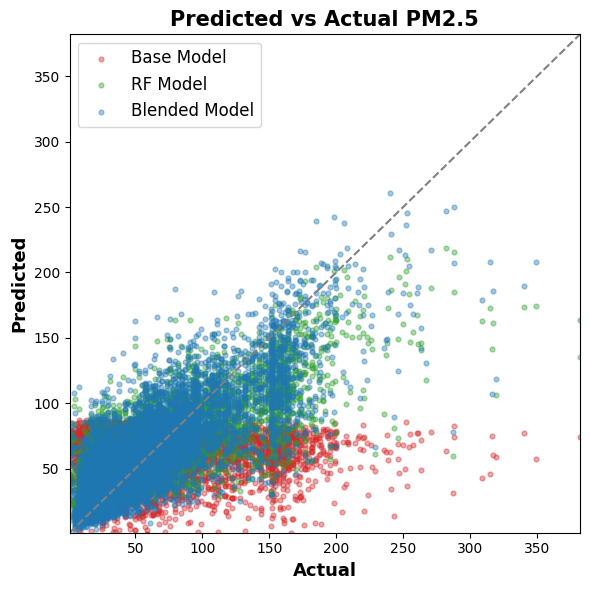

In [86]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, s=12, alpha=0.4, color='tab:red', label='Base Model')
plt.scatter(y_test, y_preds["RandomForestRegressor"], s=12, alpha=0.4, color='tab:green', label='RF Model')
plt.scatter(y_test, pred_full, s=12, alpha=0.4, color='tab:blue', label='Blended Model')
lims = [min(y_test.min(), pred_full.min()), max(y_test.max(), pred_full.max())]
plt.plot(lims, lims, '--', color='gray')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Actual',fontsize=13, fontweight="bold")
plt.ylabel('Predicted',fontsize=13, fontweight="bold")
plt.title('Predicted vs Actual PM2.5',fontsize=15, fontweight="bold")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

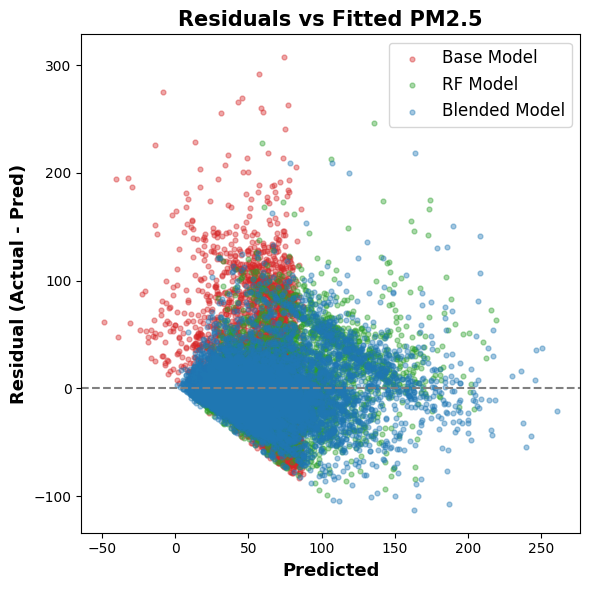

In [87]:
resid_base = y_test - preds
resid_rf = y_test - y_preds["RandomForestRegressor"]
resid_blnd = y_test - pred_full


plt.figure(figsize=(6,6))
plt.scatter(preds, resid_base,s=12, alpha=0.4, color='tab:red', label='Base Model')
plt.scatter(y_preds["RandomForestRegressor"], resid_rf,s=12, alpha=0.4, color='tab:green', label='RF Model')
plt.scatter(pred_full, resid_blnd,s=12, alpha=0.4, color='tab:blue', label='Blended Model')
plt.axhline(0, ls='--', color='gray')
plt.xlabel('Predicted',fontsize=13, fontweight="bold")
plt.ylabel('Residual (Actual - Pred)',fontsize=13, fontweight="bold")
plt.title('Residuals vs Fitted PM2.5',fontsize=15, fontweight="bold")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


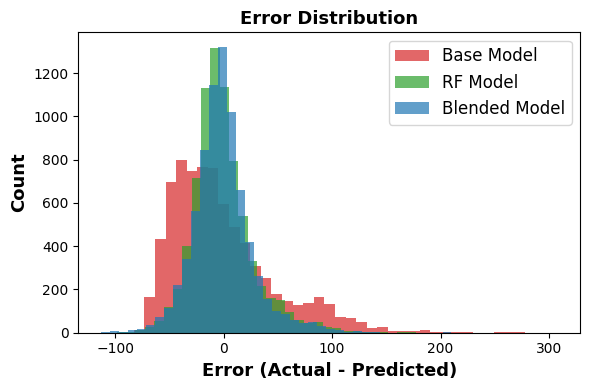

In [88]:
err_b = y_test - preds
err_rf= y_test - y_preds["RandomForestRegressor"] 
err_blnd = y_test - pred_r

plt.figure(figsize=(6,4))
plt.hist(err_b, bins=40, alpha=0.7,color='tab:red',label='Base Model')
plt.hist(err_rf, bins=40, alpha=0.7,color='tab:green',label='RF Model')
plt.hist(err_blnd, bins=40, alpha=0.7,color='tab:blue',label='Blended Model')
plt.xlabel('Error (Actual - Predicted)',fontsize=13, fontweight="bold")
plt.ylabel('Count',fontsize=13, fontweight="bold")
plt.title('Error Distribution',fontsize=13, fontweight="bold")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [90]:
def slice_scores(frame, y_true, pred_r, by, min_rows=30, sort='rmse'):
    """
    frame : DataFrame with the slice columns (e.g., zone/no2_bin/co_bin)
    y_true: 1D array of true targets aligned to frame
    y_pred: 1D array of predictions aligned to frame
    by    : list of column names to group by (e.g., ['zone','no2_bin','co_bin'])
    min_rows : require at least this many rows per slice; smaller ones get NaN metrics
    sort : 'rmse' (asc) or 'r2' (desc)
    """
    df_ = frame.copy()
    df_['y_true'] = np.asarray(y_true)
    df_['y_pred'] = np.asarray(pred_r)

    def stats(g):
        n = len(g)
        if n < min_rows:
            return pd.Series({'n': n, 'rmse': np.nan, 'r2': np.nan})
        rmse = root_mean_squared_error(g['y_true'], g['y_pred'])
        r2   = r2_score(g['y_true'], g['y_pred'])
        return pd.Series({'n': n, 'rmse': rmse, 'r2': r2})

    out = df_.groupby(by, dropna=False).apply(stats).reset_index()
    if sort == 'rmse':
        out = out.sort_values(['rmse','n'], ascending=[True, False])
    elif sort == 'r2':
        out = out.sort_values(['r2','n'], ascending=[False, False])
    return out


# Build the slice table (example)
tbl = slice_scores(df_test, y_test, pred_r,
                   by=['zone','no2_bin','co_bin','voc_bin',"wind_bin"])

# 1) Max n across all slices
max_n = tbl['n'].max()
print("Max n:", max_n)
print('====================')

# 2) Which slice(s) have that max n
print(tbl[tbl['n'] == max_n])
print('====================')


# 3) Top-10 slices by n
print(tbl.head(50))
print('====================')




# 4) Also useful: show n as % of total test rows
total = len(df_test)
tbl = tbl.assign(n_pct=(tbl['n'] / total * 100).round(2))
#print(tbl.sort_values('n', ascending=False).head(10)[['zone','no2_bin','co_bin','voc_bin','n','n_pct']])

Max n: 673.0
        zone no2_bin  co_bin     voc_bin wind_bin      n       rmse        r2
1285  winter   rural  low_co  background   breezy  673.0  16.624941  0.331694
          zone     no2_bin       co_bin     voc_bin wind_bin      n   
649     summer       rural       low_co         low   breezy   42.0  \
969   tropical       rural       low_co         low   breezy   87.0   
644     summer       rural       low_co  background    light   47.0   
1048  tropical  peri-urban       low_co         low    light   41.0   
1525    winter     unknown       low_co  background   breezy   60.0   
965   tropical       rural       low_co  background   breezy   66.0   
1285    winter       rural       low_co  background   breezy  673.0   
645     summer       rural       low_co  background   breezy   54.0   
1345    winter       rural      unknown  background   breezy   47.0   
1297    winter       rural       low_co     unknown   breezy  189.0   
1286    winter       rural       low_co  backgroun